# Generates a graph based on the temporal occurence of each feature

### Initialization:

In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
import networkx as nx
import matplotlib.pyplot as plt

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# File Names
load_pre = '../'
images_file_name = 'Data/bear-processed.npy'
trained_bases = 'bases.npy'

In [3]:
# Number of Filters
V = 12
b = 12 
K = V*b

# Hyperparameters
stride = 9
k_sz = 12
sz = k_sz*k_sz
batch_size = 1

# Load Frames
frames = np.load(load_pre + images_file_name)
frames = frames.transpose([0, 3, 1, 2])
N, _, H, W = frames.shape
frames = frames.transpose([0, 2, 3, 1])

# Initialize Code and Firing Rates
I = tf.placeholder(tf.float32, shape=(batch_size, H, W, 1))
U = tf.placeholder(tf.float32, shape=(K, sz))

### Functions

In [4]:
# Soft thresholding operator
def _soft_th(x, param):
    x_sign = tf.sign(x)
    x_reduced = tf.nn.relu(tf.subtract(tf.abs(x), param))
    x_soft = tf.multiply(x_sign, x_reduced)

    return x_soft


# Computes intitial size of feature maps
def compute_feats(I, filters):
    filters = tf.reshape(filters, [1, K, k_sz, k_sz])
    filters = tf.transpose(filters, [2, 3, 0, 1])
    alpha = tf.nn.conv2d(I, filters, strides=[
                         1, stride, stride, 1], padding='SAME')

    h1 = alpha.get_shape()[1]
    w1 = alpha.get_shape()[2]

    alpha = tf.reshape(alpha, [-1, h1, w1, K])

    return alpha, h1, w1


# Deconvolves features to reconstruct the input
def deconv_generator(alpha, filters):
    filters = tf.reshape(filters, [1, K, k_sz, k_sz])
    filters = tf.transpose(filters, [2, 3, 0, 1])
    img = tf.nn.conv2d_transpose(alpha, filters, output_shape=[
                                 batch_size, H, W, 1],
                                 strides=[1, stride, stride, 1],
                                 padding='SAME')
    return img


# MSE loss function
def MSE(y, y_hat):
    dim0 = tf.shape(y)[0]
    y = tf.reshape(y, [dim0, -1])
    y_hat = tf.reshape(y_hat, [dim0, -1])
    return tf.reduce_mean(tf.reduce_sum(tf.square(y-y_hat), axis=-1))


# FISTA loop for sparse inference: rectify=True makes the code nonnegative
def fista_loop(loss, prev, curr, y, t, eta, gamma, rectify=False):

    grad_y = tf.gradients(xs=y, ys=loss)[0]

    y = y - eta*grad_y
    y = tf.nn.relu(_soft_th(y, eta*gamma))

    if rectify:
        y = tf.nn.relu(y)
    y = tf.stop_gradient(y)

    prev = curr
    curr = y
    y = curr + (((t+1)-2)/((t+1)+1))*(curr-prev)

    y = tf.stop_gradient(y)
    return prev, curr, y


# reconstruct and compute loss
def rec_loss(alpha, filters, I):
    I_hat = deconv_generator(alpha, filters)
    return MSE(I, I_hat)


# Project features to unit l2 norm after each gradient descent step
def project_basis(basis):
    norm = 1e-8+np.sqrt(np.sum(np.square(basis), axis=-1, keepdims=True))
    return basis/norm

### Tensorflow Computation

In [5]:
# Compute initial feature map and zero it out (you can also comment the *= 0
# line and see how it affects inference)
alpha, h1, w1 = compute_feats(I, U)
alpha *= 0

# eta is the gradient descent step size
# gamma is the sparsity penalty strength (large == more sparse)
eta = 4e-2
gamma = 1e-2

# hist keeps track of the loss for debug purposes
hist = tf.zeros((0, 1))

y = alpha
curr = alpha
prev = alpha
lambda_dense = 1e-1

# change the number of iterations accordingly if the optimization has not
# converged. You can use hist for this (plot it and see if the loss has
# saturated)

for i in range(50):
    mse = rec_loss(y, U, I)
    prev, curr, y = fista_loop(mse, prev, curr, y, i, eta, gamma, rectify=True)
    hist = tf.concat((hist, tf.reshape(mse, [1, 1])), axis=0)

alpha = tf.stop_gradient(curr)
I_hat = deconv_generator(alpha, U)
mse = rec_loss(alpha, U, I)


# This parts displays the features nicely
leaves = tf.reshape(U, [V, b, sz])
tiled_leaves = tf.zeros((0, b*k_sz))

for i in range(V):

    row_leaves = tf.zeros((k_sz, 0))

    for j in range(b):
        row_leaves = tf.concat([row_leaves, tf.reshape(
            tf.slice(leaves, [i, j, 0], [1, 1, -1]), [k_sz, k_sz])], axis=-1)

    tiled_leaves = tf.concat([tiled_leaves, row_leaves], axis=0)

### Construct Graph

In [6]:
# Params for session
percentile = 75

In [7]:
# Run session
with tf.Session() as sess:
    # Tensorflow initialization
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    # load features
    F = np.load(load_pre + trained_bases)
    F = F.reshape([-1, sz])
    
    # Initialize graph
    G = nx.complete_graph(F.shape[0], nx.DiGraph())
    
    # Add self edges
    for n in G.nodes:
        G.add_edge(n,n)
    
    # Add weights
    for e in G.edges:
        u, v = e
        G.edges[u,v]['weight'] = 0
    
    first_run = True
    old_code = []

    # Run for 100 epochs (can exit after any epoch)
    for epoch in range(100):
        for index in range(N):
            # Log every 10
            if index % 10 == 0:
                print("Iteration: ", index)                
            
            # Get index for set of 3 frames
            fidx = np.random.randint(0, N - 3, batch_size)

            # Loop through the 3 frames
            for i in range(3):
                # Calculate loss, code and histogram
                sequence = frames[fidx + i, :, :, 0].reshape([batch_size, H, W, 1])
                run_loss, code, HIST = sess.run(
                    [mse, alpha, hist],
                    feed_dict={I: sequence, U: F})

                # Reshape and average the code
                code = code.reshape(K, -1)
                code = np.mean(code, 1)
                
                # Consider codes above threshold
                new_code  = [i for i, x in enumerate(code) if x > np.percentile(code, percentile)]
                
                # On the first run load the code. Else update the weights
                if first_run:
                    first_run = False
                else:
                    for u in old_code:
                        for v in new_code:
                            G.edges[u, v]['weight'] += 1
                            
                old_code = new_code
        
        # Continue if the user wants to
        print("Continue? (c)")
        if input() != 'c':
            break
            

Iteration:  0
Iteration:  10
Iteration:  20
Iteration:  30
Iteration:  40
Iteration:  50
Iteration:  60
Iteration:  70
Iteration:  80
Iteration:  90
Iteration:  100
Iteration:  110
Iteration:  120
Iteration:  130
Iteration:  140
Iteration:  150
Iteration:  160
Iteration:  170
Iteration:  180
Iteration:  190
Iteration:  200
Iteration:  210
Iteration:  220
Iteration:  230
Iteration:  240
Iteration:  250
Iteration:  260
Continue? (c)
n


### Visualize

In [8]:
# Stats before cleaning
print("Edges: ", G.number_of_edges(), ". Nodes: ", G.number_of_nodes())
print("Cleaning...")

# Threshold data and clean
edge_weights = nx.get_edge_attributes(G,'weight')
G.remove_edges_from((e for e, w in edge_weights.items() if w < 45)) # TODO: normalize threshold to max_edge?
G.remove_nodes_from(list(nx.isolates(G)))

# Stats after cleaning
print("Edges: ", G.number_of_edges(), ". Nodes: ", G.number_of_nodes())

Edges:  20736 . Nodes:  144
Cleaning...
Edges:  6288 . Nodes:  105


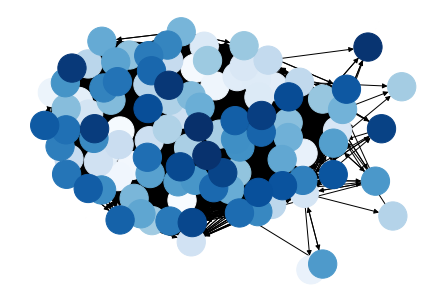

In [9]:
# Draw graph
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, node_color=range(G.number_of_nodes()), node_size=800, cmap=plt.cm.Blues)
plt.show()

{46}


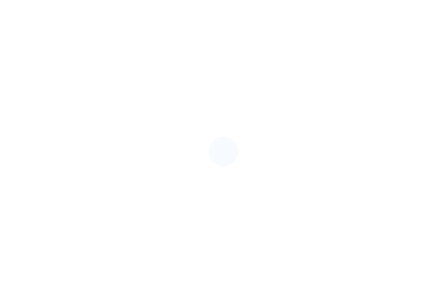

{10}


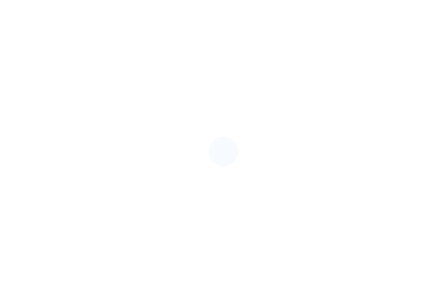

{2, 4, 5, 6, 7, 8, 9, 11, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 61, 62, 63, 64, 65, 68, 69, 70, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 93, 94, 95, 96, 101, 102, 103, 104, 106, 107, 108, 109, 110, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 126, 127, 128, 129, 130, 133, 134, 135, 139, 140, 141}


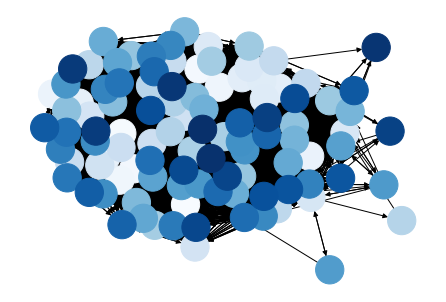

In [10]:
# Draw a graph for each strongly connected component
components = nx.strongly_connected_components(G)
for component in components:
    print(component)
    subgraph = G.subgraph(component)
    nx.draw(subgraph, pos, node_color=range(subgraph.number_of_nodes()), node_size=800, cmap=plt.cm.Blues)
    plt.show()

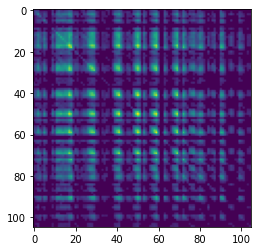

In [11]:
# Draw the adjacency matrix
adj_matrix = nx.to_numpy_matrix(G)
plt.imshow(adj_matrix)
plt.show()

(array([ 6.,  3.,  1.,  2.,  3.,  2.,  4.,  4.,  6.,  4.,  5.,  5., 10.,
         8.,  6.,  4.,  7.,  9., 11.,  5.]),
 array([  1.  ,  10.95,  20.9 ,  30.85,  40.8 ,  50.75,  60.7 ,  70.65,
         80.6 ,  90.55, 100.5 , 110.45, 120.4 , 130.35, 140.3 , 150.25,
        160.2 , 170.15, 180.1 , 190.05, 200.  ]),
 <a list of 20 Patch objects>)

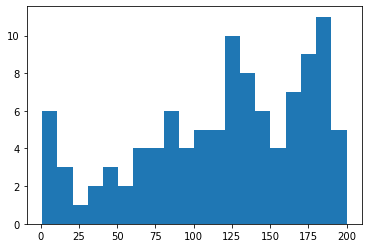

In [12]:
# Draw histogram of degrees
degrees = [val for (node, val) in G.degree()]
degrees.sort()
plt.hist(degrees, bins=20)